># Ensemble Multiple Models

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip "/content/drive/MyDrive/Dataset/data.zip"

In [5]:
gpus = tf.config.list_logical_devices('GPU')
stg=tf.distribute.MirroredStrategy(gpus)

In [6]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/data'
SIZE = 224
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE,SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1)

Processing Images: 100%|██████████| 10379/10379 [00:18<00:00, 546.60it/s]


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [8]:
batch_size = 32
picture_size = (224, 224)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed = 22
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed = 22
)

Found 10379 files belonging to 38 classes.
Using 8304 files for training.
Found 10379 files belonging to 38 classes.
Using 2075 files for validation.


In [9]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, InceptionV3, ResNet50, EfficientNetB0

In [10]:
no_of_classes = 38

# Function to build pre-trained models
def build_model(base_model):
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(38, activation='softmax')(x)  # Assuming 38 classes

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load pre-trained models
models = [
    Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
]

# Build and compile models
ensemble_models = [build_model(model) for model in models]

16705208/16705208 [==============================] - 0s 0us/step


In [11]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=2,
                                verbose=1)

callbacks = [lr_scheduler, early_stopping]

In [12]:
for model in ensemble_models:
    model.fit(train_set,
              epochs=100,
              validation_data=validation_set,
              callbacks=callbacks,
              steps_per_epoch=len(train_set),
              validation_steps=len(validation_set))

Epoch 1/100
260/260 [==============================] - 56s 177ms/step - loss: 7.1985 - accuracy: 0.0281 - val_loss: 3.6387 - val_accuracy: 0.0342 - lr: 0.0010
Epoch 2/100
260/260 [==============================] - 44s 169ms/step - loss: 3.6370 - accuracy: 0.0303 - val_loss: 3.6404 - val_accuracy: 0.0270 - lr: 0.0010
Epoch 3/100
260/260 [==============================] - ETA: 0s - loss: 3.6388 - accuracy: 0.0301
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
260/260 [==============================] - 44s 169ms/step - loss: 3.6388 - accuracy: 0.0301 - val_loss: 3.6404 - val_accuracy: 0.0270 - lr: 0.0010
Epoch 3: early stopping
Epoch 1/100
260/260 [==============================] - 37s 111ms/step - loss: 6.4079 - accuracy: 0.0271 - val_loss: 3.6373 - val_accuracy: 0.0347 - lr: 0.0010
Epoch 2/100
260/260 [==============================] - 24s 90ms/step - loss: 3.6397 - accuracy: 0.0296 - val_loss: 3.6376 - val_accuracy: 0.0275 - lr: 0.0010
Epoch 3/100
259/260 

In [14]:
# Ensemble predictions
ensemble_predictions = []
test_data_dir = '/content/data'  # Adjust this path
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=picture_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

for model in ensemble_models:
    predictions = model.predict(test_generator)
    ensemble_predictions.append(predictions)

ensemble_predictions = np.mean(ensemble_predictions, axis=0)

# Calculate the accuracy of the ensemble predictions (if you have labels for test data)
ensemble_acc = np.mean(np.argmax(ensemble_predictions, axis=1) == test_generator.classes)
print('Ensemble accuracy:', ensemble_acc)

Found 10379 images belonging to 38 classes.
325/325 [==============================] - 25s 70ms/step
Ensemble accuracy: 0.9582811446189421


Ensemble accuracy: 0.9582811446189421
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       283
           1       0.97      0.99      0.98       270
          10       0.96      0.95      0.95       299
          11       0.96      0.97      0.97       240
          12       0.98      0.96      0.97       267
          13       0.97      0.96      0.97       278
          14       0.95      0.92      0.94       298
          15       0.91      0.96      0.93       290
          16       0.97      1.00      0.98       252
          17       0.97      0.99      0.98       262
          18       0.94      0.97      0.96       265
          19       0.86      0.96      0.91       256
           2       0.95      0.94      0.94       254
          20       0.98      0.97      0.98       282
          21       0.97      0.98      0.97       278
          22       0.94      0.98      0.96       283
          23       0

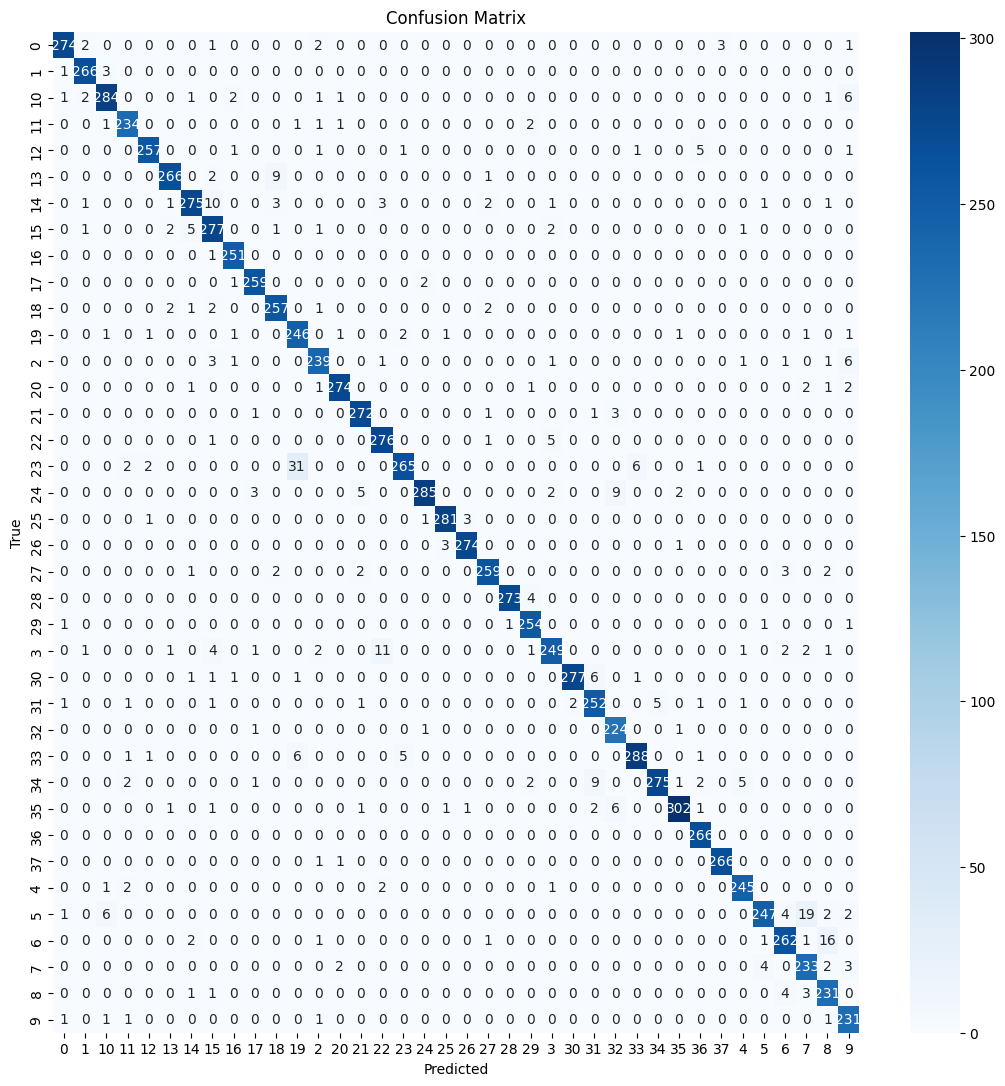

F1 Score: 0.9582724921055067
Overall AUC-ROC Score: 0.9993723900175967


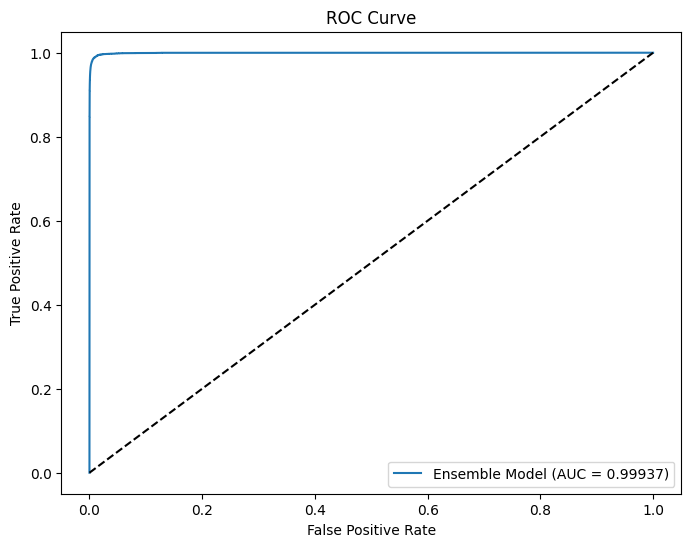

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate accuracy
ensemble_acc = accuracy_score(np.argmax(ensemble_predictions, axis=1), test_generator.classes)
print('Ensemble accuracy:', ensemble_acc)

# Extract class labels
class_labels = list(test_generator.class_indices.keys())

# Generate classification report
report = classification_report(np.argmax(ensemble_predictions, axis=1), test_generator.classes, target_names=class_labels)
print('Classification Report:')
print(report)

# Generate confusion matrix
cm = confusion_matrix(np.argmax(ensemble_predictions, axis=1), test_generator.classes)
plt.figure(figsize=(13, 13))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate F1 score
f1 = f1_score(np.argmax(ensemble_predictions, axis=1), test_generator.classes, average='weighted')
print('F1 Score:', f1)

# Calculate overall AUC-ROC
y_true = tf.keras.utils.to_categorical(test_generator.classes)
# Flatten the one-hot encoded true labels and predicted probabilities
y_true_flat = y_true.ravel()
ensemble_predictions_flat = ensemble_predictions.ravel()
auc_roc = roc_auc_score(y_true_flat, ensemble_predictions_flat)
print('Overall AUC-ROC Score:', auc_roc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true_flat, ensemble_predictions_flat)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Ensemble Model (AUC = {:.5f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()